## Simulation - Robustness Analysis

### Single Thruster Failure
**Approach 1**: the N-thruster system is aware of the failure and starts acting as a (N-1)-thruster system \
**Approach 2**: the N-thruster system is not aware of the failure and computes required thrust output for regular case, afterwards random thruster is set to 0.0 and T_c (actual) is updated accordingly \
**Approach 3**: the N-thruster system is aware of the failure and starts acting as a (N-1)-thruster system, when this does not solve, simply set thruster value to zero and update T_c 

### Import packages

In [1]:
import numpy as np
import scipy as sc
import os
import re
from scipy.integrate import RK45
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from astroquery.jplhorizons import Horizons
import datetime
import sys
import control as c
import serial as serial
import classes as cl
from astropy.time import Time
import cvxpy as cp
import random

### Omega experiment - smaller gains

In [2]:
# Set-up 1
tau_11 = np.cross(np.array([0.1, 0.15, 0]), np.array([-1,0,0]))
tau_12 = np.cross(np.array([-0.1, 0.15, 0]), np.array([1,0,0]))
tau_13 = np.cross(np.array([0, 0.15, 0.1]), np.array([0,0,-1]))
tau_14 = np.cross(np.array([0, -0.15, 0.1]), np.array([0,0,-1]))
tau_15 = np.cross(np.array([0.1, 0, 0.1]), np.array([-1,0,0]))
tau_16 = np.cross(np.array([-0.1, 0, 0.1]), np.array([1,0,0]))

# Set-up 2
tau_21 = np.cross(np.array([0.1, 0.15, 0.1]), np.array([-1,0,0]))
tau_22 = np.cross(np.array([-0.1, 0.15, 0.1]), np.array([1,0,0]))
tau_23 = np.cross(np.array([0, 0.15, 0.1]), np.array([0,0,-1]))
tau_24 = np.cross(np.array([0, -0.15, 0.1]), np.array([0,0,-1]))
tau_25 = np.cross(np.array([0.1, -0.15, 0.1]), np.array([-1,0,0]))
tau_26 = np.cross(np.array([-0.1, -0.15, 0.1]), np.array([1,0,0]))

# Set-up 3
tau_31 = np.cross(np.array([0.1, 0.15, 0]), np.array([-1,0,0]))
tau_32 = np.cross(np.array([-0.1, 0.15, 0]), np.array([1,0,0]))
tau_33 = np.cross(np.array([0, 0.15, 0.1]), np.array([0,0,-1]))
tau_34 = np.cross(np.array([0, -0.15, 0.1]), np.array([0,0,-1]))
tau_35 = np.cross(np.array([0.1, 0, 0.1]), np.array([-1,0,0]))
tau_36 = np.cross(np.array([-0.1, 0, 0.1]), np.array([1,0,0]))
tau_37 = np.cross(np.array([0.1, -0.15, -0.1]), np.array([0,1,0]))
tau_38 = np.cross(np.array([-0.1, -0.15, -0.1]), np.array([0,1,0]))

# Set-up 4
tau_41 = np.cross(np.array([0.1, -0.15, 0.1]), np.array([0,1,0]))
tau_42 = np.cross(np.array([0.1, -0.15, 0.1]), np.array([-1,0,0]))
tau_43 = np.cross(np.array([0.1, -0.15, 0.1]), np.array([0,0,-1]))
tau_44 = np.cross(np.array([-0.1, -0.15, 0.1]), np.array([1,0,0]))
tau_45 = np.cross(np.array([-0.1, -0.15, 0.1]), np.array([0,1,0]))
tau_46 = np.cross(np.array([-0.1, -0.15, 0.1]), np.array([0,0,-1]))
tau_47 = np.cross(np.array([0.1, -0.15, -0.1]), np.array([-1,0,0]))
tau_48 = np.cross(np.array([0.1, -0.15, -0.1]), np.array([0,1,0]))
tau_49 = np.cross(np.array([0.1, -0.15, -0.1]), np.array([0,0,1]))
tau_410 = np.cross(np.array([-0.1, -0.15, -0.1]), np.array([0,0,1]))
tau_411 = np.cross(np.array([-0.1, -0.15, -0.1]), np.array([0,1,0]))
tau_412 = np.cross(np.array([-0.1, -0.15, -0.1]), np.array([1,0,0]))

# Stack the tau vectors into a 3x6 matrix
T_matrix_1 = np.column_stack((tau_11, tau_12, tau_13, tau_14, tau_15, tau_16))
T_matrix_2 = np.column_stack([tau_21, tau_22, tau_23, tau_24, tau_25, tau_26])
T_matrix_3 = np.column_stack([tau_31, tau_32, tau_33, tau_34,tau_35, tau_36, tau_37, tau_38])
T_matrix_4 = np.column_stack([tau_41, tau_42, tau_43, tau_44,tau_45, tau_46, tau_47, tau_48, tau_49, tau_410, tau_411, tau_412])

In [117]:
def simulation(
    data_file_CAPSTONE,
    data_file_Sun,
    omega_0,
    kp,
    kd,
    ks,
    T_matrix,
    matrixnumber
):
    # Load data files
    data_CAPSTONE = np.loadtxt(data_file_CAPSTONE)
    data_Sun = np.loadtxt(data_file_Sun)

    # Load data files
    data_CAPSTONE = np.loadtxt(data_file_CAPSTONE)
    data_Sun = np.loadtxt(data_file_Sun)

    # Extract metadata from data_file_CAPSTONE filename using regular expressions
    # Looks for date and time in the format YYYY-MM-DD HH:MM
    filename = os.path.basename(data_file_CAPSTONE)
    datetime_matches = re.findall(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}', filename)

    if len(datetime_matches) >= 2:
        startdate = datetime_matches[0].replace(":", "-").replace(" ", "_")
        enddate = datetime_matches[1].replace(":", "-").replace(" ", "_")
    else:
        raise ValueError("Could not extract start and end date-times from the filename.")

    # Define save directory
    save_dir = "/Users/Pieter/Library/Mobile Documents/com~apple~CloudDocs/Thesis/Research Phase/lunar_CubeSat/results/data"
    os.makedirs(save_dir, exist_ok=True)

    # Create time array based on the input data files and check if they cover the same epochs
    time_array = data_CAPSTONE[:, 0]
    time_array_check = data_Sun[:, 0]
    if time_array.all() != time_array_check.all():
        raise ValueError(
            "Epochs of the data files are not the same; check ephemeris retrieval."
        )

    # Obtain position data over time
    position_CAPSTONE = data_CAPSTONE[:, 1:4]
    position_Sun = data_Sun[:, 1:4]

    # Retrieve time step from data file
    dt = time_array[1] - time_array[0]

    vis = cl.Visualization(time_array)
    const = cl.Constants()
    rot = cl.Rotation()
    pd = cl.PID(const.inertia_matrix)
    dist = cl.DisturbanceTorques(const.inertia_matrix)

    # Initialize individual vectors for iteration
    # q = quaternion_0_vector # For custom initial condition
    q = pd.reference_quaternion_paper(position_CAPSTONE[0,:], position_Sun[0,:]) # For standard initial position
    omega = omega_0

    # Dummy values for PID
    factor_p = kp
    factor_i = 0
    factor_d = kd
    factor_s = ks

    # Create arrays
    k_p = np.array([1, 1, 1]) * factor_p
    k_i = np.array([1, 1, 1]) * factor_i
    k_d = np.array([1, 1, 1]) * factor_d
    k_s = np.array([1, 1, 1]) * factor_s


    # Initialize storage arrays for visualization
    q_ref_vis = np.empty((4, len(time_array)))
    q_vis = np.empty((4, len(time_array)))
    T_GG_vis = np.empty((3, len(time_array)))
    T_SRP_vis = np.empty((3, len(time_array)))
    T_d_vis = np.empty((3, len(time_array)))
    T_c_vis = np.empty((3, len(time_array)))
    T_RW_vis = np.empty((3, len(time_array)))
    P_RW_vis = np.empty((3, len(time_array)))
    E_RW_vis = np.empty((3, len(time_array)))
    omega_vis = np.empty((3, len(time_array)))
    h_vis = np.empty((3, len(time_array)))
    thrust_vis = np.empty((len(T_matrix[0]), len(time_array)))
    impulse_vis = np.empty((len(T_matrix[0]), len(time_array)))
    P_thrust_vis = np.empty((len(T_matrix[0]), len(time_array)))
    E_thrust_vis = np.empty((len(T_matrix[0]), len(time_array)))
    half_cone_offset_vis = np.empty((len(time_array)))

    # Index count and previous q_ref value
    index = 0
    previous_q_ref = None

    # Initiate angular momentum, reaction wheel energy, thrust energy, impulse
    h = 0
    E_RW = 0
    E_thrust = 0
    impulse = np.zeros(len(T_matrix[0]))

    # At the start of the simulation loop
    max_torque_magnitude = 0
    max_torque_index = -1

    for t in time_array:

        # LUMIO paper-based reference quaternion update
        q_ref = pd.reference_quaternion_paper(position_CAPSTONE[index,:], position_Sun[index,:])

        # Check quaternion continuity; do we need to flip signs?
        if previous_q_ref is not None:
            if np.dot(q_ref, previous_q_ref) < 0:
                q_ref = -q_ref
        
        # Store q_ref for next iteration
        previous_q_ref = q_ref

        # Half-cone requirement validation
        y_panel_body = np.array([0,-1,0])
        y_panel_inert = np.linalg.inv(rot.quaternion_321_rotation(q[0], q[1], q[2], q[3])) @ y_panel_body
        y_panel_inert /= np.linalg.norm(y_panel_inert)
        Moon_pointing_vector = - position_CAPSTONE[index,:]
        Moon_pointing_vector /= np.linalg.norm(Moon_pointing_vector)
        half_cone_offset = np.rad2deg(np.arccos(np.clip(np.dot(y_panel_inert, Moon_pointing_vector), -1.0, 1.0)))

        # Calculate real-time disturbance torques
        T_GG = dist.GGMoon(q, position_CAPSTONE[index, :])
        T_SRP = dist.SRP_deployed(q, position_Sun[index, :], position_CAPSTONE[index, :])
        # Dummy input zeros
        T_d = T_GG + T_SRP

        T_c = pd.control_torque(q, q_ref, omega, k_p, k_i, k_d, k_s, dt)

        # Calculate the magnitude of the torque vector
        torque_magnitude = np.linalg.norm(T_c)

        # Update maximum torque and index if the current magnitude is larger
        if torque_magnitude > max_torque_magnitude:
            max_torque_magnitude = torque_magnitude
            max_torque_index = index
        
        ######### RW ANALYSIS #######################
        # Calculate incremental increase in angular momentum of the momentum wheel
        h = const.inertia_matrix @ omega
        # Assembly configuration matrix, each reaction wheel covers one axis
        A_RW = np.array([[1,0,0], [0,1,0], [0,0,1]])
        # Torque imposed on RW assembly, nominal mode
        T_ass = np.linalg.pinv(A_RW) @ (-T_c + np.cross(A_RW @ h, omega))
        # Torque generated by the RW set, total
        T_RW = - (A_RW @ T_ass + np.cross(omega, A_RW @ h))
        # Power consumption at this time step, linear relation assumed
        P_RW = const.P_peak_max / const.T_RW_max * np.abs(T_RW)
        # Total energy consumption, power integrated over time
        E_RW += P_RW * dt
        #############################################

        ######### THRUSTER ANALYSIS #################
        # Linear Programming Solution
        thrust = cp.Variable(len(T_matrix[0]))
        constraints = [T_matrix @ thrust == T_c, thrust >= 0, thrust <= const.F_SSP_max]
        objective = cp.Minimize(cp.sum(thrust))
        problem = cp.Problem(objective, constraints)
        problem.solve()

        # # Check the solution status

        if thrust.value is None:
            thrust_value = np.zeros(len(T_matrix[0]))
        else:
            thrust_value = np.clip(thrust.value, 0, None)  # Set all values < 0 to 0

        # Add uncertainty
        sigma = 0.05  # 5% uncertainty introduced, random value
        thrust_value_actual = thrust_value.copy()  # Start with the original values
        non_zero_indices = thrust_value > 0  # Find indices where thrust value is positive

        # Apply noise only to non-zero values
        thrust_value_actual[non_zero_indices] = np.clip(
            np.random.normal(
                loc=thrust_value[non_zero_indices],
                scale=sigma * thrust_value[non_zero_indices]
            ),
            (1 - sigma) * thrust_value[non_zero_indices],
            (1 + sigma) * thrust_value[non_zero_indices]
        )

        # Update impulse value
        impulse += thrust_value_actual * dt

        # Power analysis
        # From data sheet: Input Power linear relation with thrust output, from T = 0 to T = 200 [muN] and P = 0 to 20 [W]
        # Let power input be as in original thrust case, since uncertainty comes from the output only
        P_thrust = const.P_SSP_max / const.F_SSP_max * thrust_value
        E_thrust += P_thrust * dt
        #############################################

        # Append to visualisation arrays
        q_ref_vis[:, index] = q_ref
        q_vis[:, index] = q
        T_d_vis[:, index] = T_d
        T_GG_vis[:, index] = T_GG
        T_SRP_vis[:, index] = T_SRP
        T_c_vis[:, index] = T_c
        T_RW_vis[:, index] = T_RW
        P_RW_vis[:, index] = P_RW
        E_RW_vis[:, index] = E_RW
        omega_vis[:, index] = omega
        h_vis[:, index] = h
        half_cone_offset_vis[index] = half_cone_offset
        thrust_vis[:,index] = thrust_value_actual
        impulse_vis[:,index] = impulse
        P_thrust_vis[:,index] = P_thrust
        E_thrust_vis[:,index] = E_thrust

        # Update to t = 1
        # Integrate omega and quaternion
        omega_new = pd.rk4_integrator(pd.derivative_omega, omega, dt, T_d, T_c)
        q_new = pd.rk4_integrator(pd.derivative_quaternion, q, dt, omega)
        q = q_new / np.linalg.norm(q_new)
        omega = omega_new

        # Update index
        index += 1
    
    # At the end of the simulation loop, after populating the visualization arrays
    total_PE = np.sum(P_thrust_vis, axis=0)  # Summing up all thrusters' power over time
    total_E = np.sum(E_thrust_vis[:, -1])  # Total energy is the last value of summation

    # After the loop, retrieve the torque vector with the largest magnitude
    T_c_max_vector = T_c_vis[:, max_torque_index]

    # Save each "vis" array
    vis_arrays = {
        "q_ref_vis": q_ref_vis,
        "q_vis": q_vis,
        "T_GG_vis": T_GG_vis,
        "T_SRP_vis": T_SRP_vis,
        "T_d_vis": T_d_vis,
        "T_c_vis": T_c_vis,
        "T_RW_vis": T_RW_vis,
        "P_RW_vis": P_RW_vis,
        "E_RW_vis": E_RW_vis,
        "omega_vis": omega_vis,
        "h_vis": h_vis,
        "thrust_vis": thrust_vis,
        "impulse": impulse_vis,
        "P_thrust_vis": P_thrust_vis,
        "E_thrust_vis": E_thrust_vis,
        "half_cone_offset_vis": half_cone_offset_vis,
        "time_array": time_array
    }
    
    # Plot generation
    vis.quaternion_versus_time(q_ref_vis, q_vis)
    # vis.euler_versus_time(q_ref_vis, q_vis)
    vis.control_torque_versus_time(T_c_vis)
    # vis.RW_PE_versus_time(P_RW_vis, "P")
    # vis.RW_PE_versus_time(E_RW_vis, "E")
    # vis.h_versus_time(h_vis)
    # vis.disturbance_torque_versus_time(T_d_vis, T_GG_vis, T_SRP_vis)
    # vis.omega_versus_time(omega_vis)
    # vis.plot_trajectories(data_file_CAPSTONE)
    # vis.thruster_PE_vs_time(P_thrust_vis, "P")
    # vis.thruster_PE_vs_time(E_thrust_vis, "E")
    # vis.combined_PE_vs_time(P_RW_vis, P_thrust_vis, "P")
    # vis.combined_PE_vs_time(E_RW_vis, E_thrust_vis, "E")
    # vis.thrust_values(thrust_vis)
    
    # Return required values
    return {
        "max_torque_vector": T_c_max_vector,
        "max_torque_magnitude": max_torque_magnitude
    }




In [ ]:
kp_new = 5e-2
kd_new = 5e-2
ks_new = 12

omega_0_00 =  np.array([0, 0, 0])

rob_1 = simulation(
"converted_ephemeris_data/converted_1s_cartesian_coordinates_CAPSTONE_Moon-centered_2023-01-01 00:00_to_2023-01-01 00:02_1m.dat",
"converted_ephemeris_data/converted_1s_cartesian_coordinates_Sun_Moon-centered_2023-01-01 00:00_to_2023-01-01 00:02_1m.dat",
np.array([np.deg2rad(10132), np.deg2rad(0), np.deg2rad(0)]),
kp_new,
kd_new,
ks_new,
T_matrix_1, "1")

print(rob_1)

### Simulation - Thruster setups

Additional explanation per setup here (incl. figure)

In [ ]:
# Set-up 1
tau_11 = np.cross(np.array([0.1, 0.15, 0]), np.array([-1,0,0]))
tau_12 = np.cross(np.array([-0.1, 0.15, 0]), np.array([1,0,0]))
tau_13 = np.cross(np.array([0, 0.15, 0.1]), np.array([0,0,-1]))
tau_14 = np.cross(np.array([0, -0.15, 0.1]), np.array([0,0,-1]))
tau_15 = np.cross(np.array([0.1, 0, 0.1]), np.array([-1,0,0]))
tau_16 = np.cross(np.array([-0.1, 0, 0.1]), np.array([1,0,0]))

# Set-up 2
tau_21 = np.cross(np.array([0.1, 0.15, 0.1]), np.array([-1,0,0]))
tau_22 = np.cross(np.array([-0.1, 0.15, 0.1]), np.array([1,0,0]))
tau_23 = np.cross(np.array([0, 0.15, 0.1]), np.array([0,0,-1]))
tau_24 = np.cross(np.array([0, -0.15, 0.1]), np.array([0,0,-1]))
tau_25 = np.cross(np.array([0.1, -0.15, 0.1]), np.array([-1,0,0]))
tau_26 = np.cross(np.array([-0.1, -0.15, 0.1]), np.array([1,0,0]))

# Set-up 3
tau_31 = np.cross(np.array([0.1, 0.15, 0]), np.array([-1,0,0]))
tau_32 = np.cross(np.array([-0.1, 0.15, 0]), np.array([1,0,0]))
tau_33 = np.cross(np.array([0, 0.15, 0.1]), np.array([0,0,-1]))
tau_34 = np.cross(np.array([0, -0.15, 0.1]), np.array([0,0,-1]))
tau_35 = np.cross(np.array([0.1, 0, 0.1]), np.array([-1,0,0]))
tau_36 = np.cross(np.array([-0.1, 0, 0.1]), np.array([1,0,0]))
tau_37 = np.cross(np.array([0.1, -0.15, -0.1]), np.array([0,1,0]))
tau_38 = np.cross(np.array([-0.1, -0.15, -0.1]), np.array([0,1,0]))

# Set-up 4
tau_41 = np.cross(np.array([0.1, -0.15, 0.1]), np.array([0,1,0]))
tau_42 = np.cross(np.array([0.1, -0.15, 0.1]), np.array([-1,0,0]))
tau_43 = np.cross(np.array([0.1, -0.15, 0.1]), np.array([0,0,-1]))
tau_44 = np.cross(np.array([-0.1, -0.15, 0.1]), np.array([1,0,0]))
tau_45 = np.cross(np.array([-0.1, -0.15, 0.1]), np.array([0,1,0]))
tau_46 = np.cross(np.array([-0.1, -0.15, 0.1]), np.array([0,0,-1]))
tau_47 = np.cross(np.array([0.1, -0.15, -0.1]), np.array([-1,0,0]))
tau_48 = np.cross(np.array([0.1, -0.15, -0.1]), np.array([0,1,0]))
tau_49 = np.cross(np.array([0.1, -0.15, -0.1]), np.array([0,0,1]))
tau_410 = np.cross(np.array([-0.1, -0.15, -0.1]), np.array([0,0,1]))
tau_411 = np.cross(np.array([-0.1, -0.15, -0.1]), np.array([0,1,0]))
tau_412 = np.cross(np.array([-0.1, -0.15, -0.1]), np.array([1,0,0]))

# Stack the tau vectors into a 3x6 matrix
T_matrix_1 = np.column_stack((tau_11, tau_12, tau_13, tau_14, tau_15, tau_16))
T_matrix_2 = np.column_stack([tau_21, tau_22, tau_23, tau_24, tau_25, tau_26])
T_matrix_3 = np.column_stack([tau_31, tau_32, tau_33, tau_34,tau_35, tau_36, tau_37, tau_38])
T_matrix_4 = np.column_stack([tau_41, tau_42, tau_43, tau_44,tau_45, tau_46, tau_47, tau_48, tau_49, tau_410, tau_411, tau_412])

### Simulation - Main function

In [ ]:
"""
For the simulation to run, a number of input values are needed. These are:
- Reference quaternions
- Quaternion attitude at t = 0
- Angular velocity at t = 0
- Time array for simulation, based on mission geometry
- Simulation time step

Starting off simply, a number of assumptions will be made on the ki, kp, kd values, as well as on the disturbance torques. Time array will not be retrieved from the mission geometry yet either.
"""


def simulation(
    data_file_CAPSTONE,
    data_file_Sun,
    omega_0,
    kp,
    kd,
    ks,
    T_matrix
):
    # Load data files
    data_CAPSTONE = np.loadtxt(data_file_CAPSTONE)
    data_Sun = np.loadtxt(data_file_Sun)

    # Create time array based on the input data files and check if they cover the same epochs
    time_array = data_CAPSTONE[:, 0]
    time_array_check = data_Sun[:, 0]
    if time_array.all() != time_array_check.all():
        raise ValueError(
            "Epochs of the data files are not the same; check ephemeris retrieval."
        )

    # Obtain position data over time
    position_CAPSTONE = data_CAPSTONE[:, 1:4]
    position_Sun = data_Sun[:, 1:4]

    # Retrieve time step from data file
    dt = time_array[1] - time_array[0]

    vis = cl.Visualization(time_array)
    const = cl.Constants()
    rot = cl.Rotation()
    pd = cl.PID(const.inertia_matrix_undeployed)
    dist = cl.DisturbanceTorques(const.inertia_matrix_undeployed)

    # Initialize individual vectors for iteration
    # q = quaternion_0_vector # For custom initial condition
    q = pd.reference_quaternion_paper(position_CAPSTONE[0,:], position_Sun[0,:]) # For standard initial position
    omega = omega_0

    # Dummy values for PID
    factor_p = kp
    factor_i = 0
    factor_d = kd
    factor_s = ks

    # Create arrays
    k_p = np.array([1, 1, 1]) * factor_p
    k_i = np.array([1, 1, 1]) * factor_i
    k_d = np.array([1, 1, 1]) * factor_d
    k_s = np.array([1, 1, 1]) * factor_s


    # Initialize storage arrays for visualization
    q_ref_vis = np.empty((4, len(time_array)))
    q_vis = np.empty((4, len(time_array)))
    T_GG_vis = np.empty((3, len(time_array)))
    T_SRP_vis = np.empty((3, len(time_array)))
    T_d_vis = np.empty((3, len(time_array)))
    T_c_vis = np.empty((3, len(time_array)))
    T_RW_vis = np.empty((3, len(time_array)))
    P_RW_vis = np.empty((3, len(time_array)))
    E_RW_vis = np.empty((3, len(time_array)))
    omega_vis = np.empty((3, len(time_array)))
    h_vis = np.empty((3, len(time_array)))
    thrust_vis = np.empty((len(T_matrix[0]), len(time_array)))
    P_thrust_vis = np.empty((len(T_matrix[0]), len(time_array)))
    E_thrust_vis = np.empty((len(T_matrix[0]), len(time_array)))

    # Index count
    index = 0

    # Initiate angular momentum
    h = 0
    E_RW = 0
    E_thrust = 0

    for t in time_array:

        print(t / 60 / 60)

        # LUMIO paper-based reference quaternion update
        if index % 1 == 0:
            q_ref = pd.reference_quaternion_paper(position_CAPSTONE[index,:], position_Sun[index,:])

        # Calculate real-time disturbance torques
        T_GG = dist.GGMoon(q, position_CAPSTONE[index, :])
        T_SRP = dist.SRP(q, position_Sun[index, :], position_CAPSTONE[index, :])
        # Dummy input zeros
        # T_d = np.zeros(3)
        T_d = T_GG + T_SRP

        if index % 1 == 0:
            # Calculate required variables, at t = 0
            T_c = pd.control_torque(q, q_ref, omega, k_p, k_i, k_d, k_s, dt)

            # Uncomment for reaction wheel analysis
            # T_c = np.minimum(T_c, const.T_RW_max)
            # T_c = np.maximum(T_c, -const.T_RW_max)
        
        else:
            T_c = np.zeros(3)

        ######### RW ANALYSIS #######################
        # Calculate incremental increase in angular momentum of the momentum wheel
        h += T_c * dt
        # Assembly configuration matrix, each reaction wheel covers one axis
        A_RW = np.array([[1,0,0], [0,1,0], [0,0,1]])
        # Torque imposed on RW assembly, nominal mode
        T_ass = np.linalg.pinv(A_RW) @ (-T_c + np.cross(A_RW @ h, omega))
        # Torque generated by the RW set, total
        T_RW = - (A_RW @ T_ass + np.cross(omega, A_RW @ h))
        # Power consumption at this time step, linear relation assumed
        P_RW = const.P_peak_max / const.T_RW_max * np.abs(T_RW)
        # Total energy consumption, power integrated over time
        E_RW += P_RW * dt
        #############################################

        ######### THRUSTER ANALYSIS #################
        # Linear Programming Solution
        thrust = cp.Variable(len(T_matrix[0]))
        constraints = [T_matrix @ thrust == T_c, thrust >= 0, thrust <= const.F_SSP_max]
        objective = cp.Minimize(cp.sum(thrust))
        problem = cp.Problem(objective, constraints)
        problem.solve()
        
        # Power analysis
        # From data sheet: Input Power linear relation with thrust output, from T = 0 to T = 200 [muN] and P = 0 to 20 [W]
        P_thrust = const.P_SSP_max / const.F_SSP_max * thrust.value
        E_thrust += P_thrust * dt
        #############################################

        # Append to visualisation arrays
        q_ref_vis[:, index] = q_ref
        q_vis[:, index] = q
        T_d_vis[:, index] = T_d
        T_GG_vis[:, index] = T_GG
        T_SRP_vis[:, index] = T_SRP
        T_c_vis[:, index] = T_c
        T_RW_vis[:, index] = T_RW
        P_RW_vis[:, index] = P_RW
        E_RW_vis[:, index] = E_RW
        omega_vis[:, index] = omega
        h_vis[:, index] = h
        thrust_vis[:,index] = thrust.value
        P_thrust_vis[:,index] = P_thrust
        E_thrust_vis[:,index] = E_thrust

        # Update to t = 1
        # Integrate omega and quaternion
        omega_new = pd.rk4_integrator(pd.derivative_omega, omega, dt, T_d, T_c)
        q_new = pd.rk4_integrator(pd.derivative_quaternion, q, dt, omega)
        q = q_new / np.linalg.norm(q_new)
        omega = omega_new

        # Update index
        index += 1

    # Plot generation
    # vis.quaternion_versus_time(q_ref_vis, q_vis)
    vis.euler_versus_time(q_ref_vis, q_vis)
    vis.control_torque_versus_time(T_c_vis)
    # vis.RW_PE_versus_time(P_RW_vis, "P")
    # vis.RW_PE_versus_time(E_RW_vis, "E")
    # vis.h_versus_time(h_vis)
    # vis.disturbance_torque_versus_time(T_d_vis)
    # vis.disturbance_torque_versus_time(T_GG_vis)
    vis.disturbance_torque_versus_time(T_SRP_vis)
    # vis.omega_versus_time(omega_vis)
    vis.plot_trajectories(data_file_CAPSTONE)
    # vis.thruster_PE_vs_time(P_thrust_vis, "P")
    # vis.thruster_PE_vs_time(E_thrust_vis, "E")
    # vis.combined_PE_vs_time(P_RW_vis, P_thrust_vis, "P")
    # vis.combined_PE_vs_time(E_RW_vis, E_thrust_vis, "E")
    # vis.thrust_values(thrust_vis)
    
    return T_GG_vis, T_SRP_vis, q_vis, q_ref_vis, E_thrust_vis, T_c_vis

### Single thruster failure (STF) - Approach 1

In [ ]:
# Failure function
def simulation_STF_1(
    data_file_CAPSTONE,
    data_file_Sun,
    omega_0,
    kp,
    kd,
    ks,
    T_matrix
):
    # Load data files
    data_CAPSTONE = np.loadtxt(data_file_CAPSTONE)
    data_Sun = np.loadtxt(data_file_Sun)

    # Create time array based on the input data files and check if they cover the same epochs
    time_array = data_CAPSTONE[:, 0]
    time_array_check = data_Sun[:, 0]
    if time_array.all() != time_array_check.all():
        raise ValueError(
            "Epochs of the data files are not the same; check ephemeris retrieval."
        )

    # Obtain position data over time
    position_CAPSTONE = data_CAPSTONE[:, 1:4]
    position_Sun = data_Sun[:, 1:4]

    # Retrieve time step from data file
    dt = time_array[1] - time_array[0]

    vis = cl.Visualization(time_array)
    const = cl.Constants()
    rot = cl.Rotation()
    pd = cl.PID(const.inertia_matrix_undeployed)
    dist = cl.DisturbanceTorques(const.inertia_matrix_undeployed)

    # Initialize individual vectors for iteration
    # q = quaternion_0_vector # For custom initial condition
    q = pd.reference_quaternion_paper(position_CAPSTONE[0,:], position_Sun[0,:]) # For standard initial position
    omega = omega_0

    # Dummy values for PID
    factor_p = kp
    factor_i = 0
    factor_d = kd
    factor_s = ks

    # Create arrays
    k_p = np.array([1, 1, 1]) * factor_p
    k_i = np.array([1, 1, 1]) * factor_i
    k_d = np.array([1, 1, 1]) * factor_d
    k_s = np.array([1, 1, 1]) * factor_s


    # Initialize storage arrays for visualization
    q_ref_vis = np.empty((4, len(time_array)))
    q_vis = np.empty((4, len(time_array)))
    T_GG_vis = np.empty((3, len(time_array)))
    T_SRP_vis = np.empty((3, len(time_array)))
    T_d_vis = np.empty((3, len(time_array)))
    T_c_vis = np.empty((3, len(time_array)))
    T_RW_vis = np.empty((3, len(time_array)))
    P_RW_vis = np.empty((3, len(time_array)))
    E_RW_vis = np.empty((3, len(time_array)))
    omega_vis = np.empty((3, len(time_array)))
    h_vis = np.empty((3, len(time_array)))
    thrust_vis = np.empty((len(T_matrix[0]), len(time_array)))
    P_thrust_vis = np.empty((len(T_matrix[0]), len(time_array)))
    E_thrust_vis = np.empty((len(T_matrix[0]), len(time_array)))

    # Index count
    index = 0

    # Initiate thruster energy
    E_thrust = 0

    # Random thruster failure, select thruster
    failed_thruster = random.randint(0, len(T_matrix[0,:]) - 1)
    print(f"Thruster {failed_thruster + 1} has been disabled.")

    for t in time_array:

        # LUMIO paper-based reference quaternion update
        if index % 1 == 0:
            q_ref = pd.reference_quaternion_paper(position_CAPSTONE[index,:], position_Sun[index,:])

        # Calculate real-time disturbance torques
        T_GG = dist.GGMoon(q, position_CAPSTONE[index, :])
        T_SRP = dist.SRP(q, position_Sun[index, :], position_CAPSTONE[index, :])
        T_d = T_GG + T_SRP

        T_c = pd.control_torque(q, q_ref, omega, k_p, k_i, k_d, k_s, dt)

        ######### THRUSTER ANALYSIS #################
        # Linear Programming Solution
        thrust = cp.Variable(len(T_matrix[0]))
        constraints = [T_matrix @ thrust == T_c, thrust >= 0, thrust <= const.F_SSP_max]

        # Set the failed thruster's output to zero, approach 1
        constraints.append(thrust[failed_thruster] == 0)

        objective = cp.Minimize(cp.sum(thrust))
        problem = cp.Problem(objective, constraints)
        problem.solve(solver = cp.ECOS)

        try:
            # Update the actual control torque value
            T_c = T_matrix @ thrust.value
        except Exception as e:
            print(f"An error occurred: {e}")

        # Power analysis
        # From data sheet: Input Power linear relation with thrust output, from T = 0 to T = 200 [muN] and P = 0 to 20 [W]
        P_thrust = const.P_SSP_max / const.F_SSP_max * thrust.value
        E_thrust += P_thrust * dt
        #############################################

        # Append to visualisation arrays
        q_ref_vis[:, index] = q_ref
        q_vis[:, index] = q
        T_d_vis[:, index] = T_d
        T_GG_vis[:, index] = T_GG
        T_SRP_vis[:, index] = T_SRP
        T_c_vis[:, index] = T_c
        omega_vis[:, index] = omega
        thrust_vis[:,index] = thrust.value
        P_thrust_vis[:,index] = P_thrust
        E_thrust_vis[:,index] = E_thrust

        # Update to t = 1
        # Integrate omega and quaternion
        omega_new = pd.rk4_integrator(pd.derivative_omega, omega, dt, T_d, T_c)
        q_new = pd.rk4_integrator(pd.derivative_quaternion, q, dt, omega)
        q = q_new / np.linalg.norm(q_new)
        omega = omega_new

        # Update index
        index += 1
    

    T_c_mag = np.sqrt(np.sum(T_c_vis**2, axis=0))
    T_d_mag = np.sqrt(np.sum(T_d_vis**2, axis=0))

    # Plot generation
    # vis.quaternion_versus_time(q_ref_vis, q_vis)
    # vis.euler_versus_time(q_ref_vis, q_vis)
    # vis.control_torque_versus_time(T_c_vis)
    # vis.RW_PE_versus_time(P_RW_vis, "P")
    # vis.RW_PE_versus_time(E_RW_vis, "E")
    # vis.h_versus_time(h_vis)
    # vis.disturbance_torque_versus_time(T_d_vis)
    # vis.disturbance_torque_versus_time(T_GG_vis)
    # vis.disturbance_torque_versus_time(T_SRP_vis)
    # vis.omega_versus_time(omega_vis)
    # vis.plot_trajectories(data_file_CAPSTONE)
    # vis.thruster_PE_vs_time(P_thrust_vis, "P")
    # vis.thruster_PE_vs_time(E_thrust_vis, "E")
    # vis.combined_PE_vs_time(P_RW_vis, P_thrust_vis, "P")
    # vis.combined_PE_vs_time(E_RW_vis, E_thrust_vis, "E")
    # vis.thrust_values(thrust_vis)
    
    return time_array, P_thrust_vis, E_thrust_vis

### STF Execution - Approach 1

In [ ]:
# Power analysis
time_ar, P_STF, E_STF = simulation_STF_1("converted_ephemeris_data/converted_1s_cartesian_coordinates_CAPSTONE_Moon-centered_2023-01-05 08:00_to_2023-01-05 15:00_1m.dat",
"converted_ephemeris_data/converted_1s_cartesian_coordinates_Sun_Moon-centered_2023-01-05 08:00_to_2023-01-05 15:00_1m.dat",
omega_0,
kp,
kd,
ks,
T_matrix_3)

P_base, E_base = simulation("converted_ephemeris_data/converted_1s_cartesian_coordinates_CAPSTONE_Moon-centered_2023-01-05 08:00_to_2023-01-05 15:00_1m.dat",
"converted_ephemeris_data/converted_1s_cartesian_coordinates_Sun_Moon-centered_2023-01-05 08:00_to_2023-01-05 15:00_1m.dat",
omega_0,
kp,
kd,
ks,
T_matrix_3)


Thruster 4 has been disabled.


/opt/miniconda3/envs/thesisenv/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)
/opt/miniconda3/envs/thesisenv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0.06934436601231109
[-1.43570608e-08  8.40012600e-09  3.74436953e-08]


<Figure size 640x480 with 0 Axes>

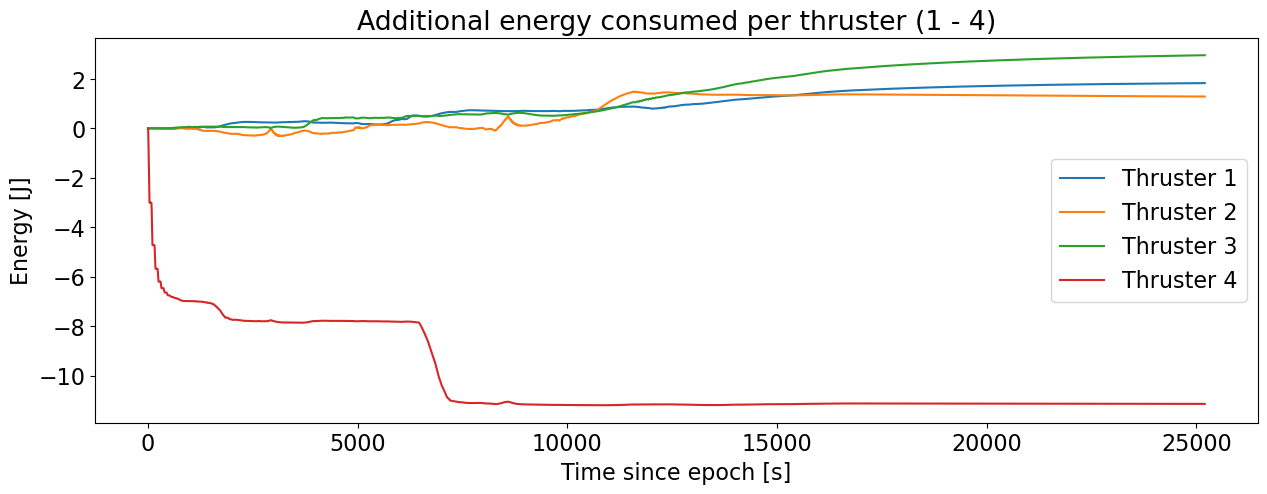

<Figure size 640x480 with 0 Axes>

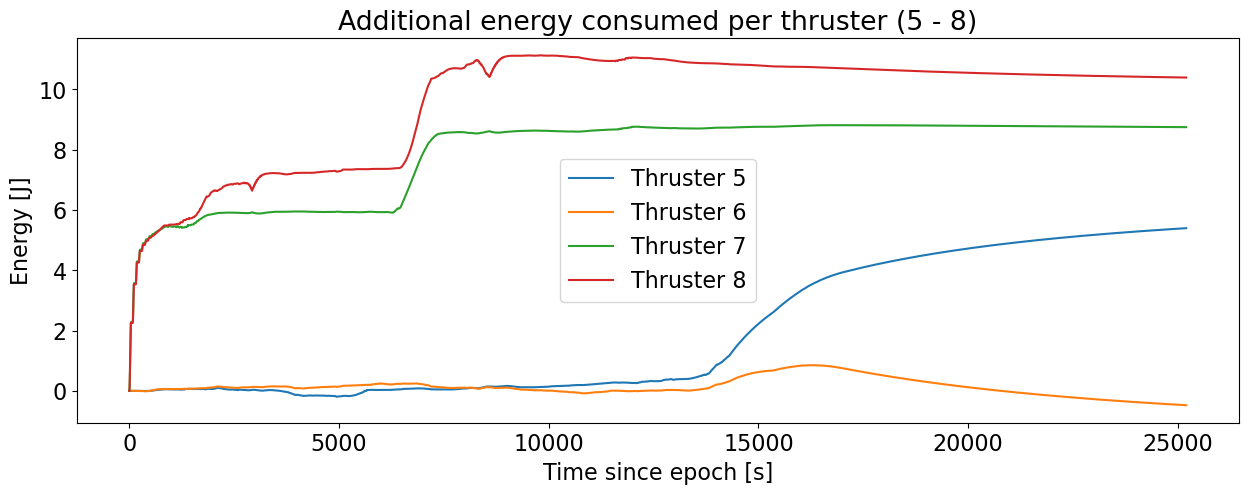

<Figure size 640x480 with 0 Axes>

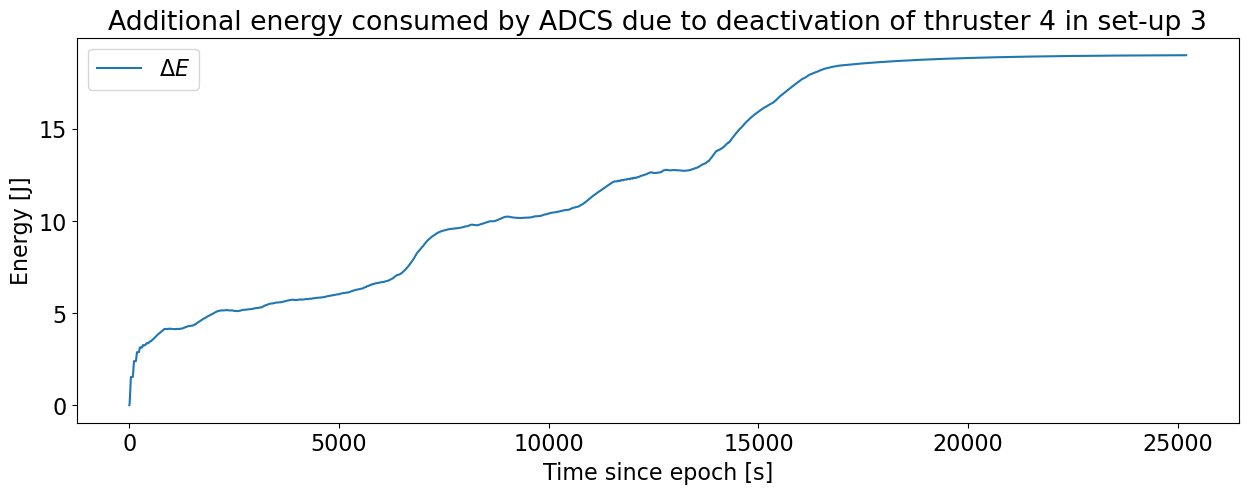

<Figure size 640x480 with 0 Axes>

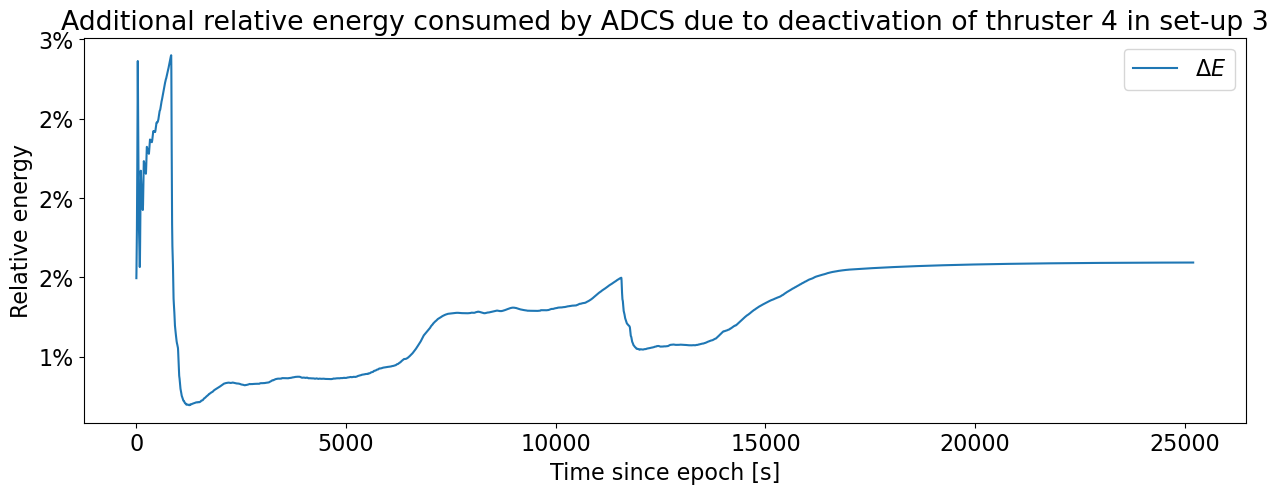

In [ ]:
from matplotlib.ticker import FuncFormatter

power_difference = E_STF - E_base # Assumption: base case requires less power

# Difference per two
plt.figure(1)
plt.figure(figsize=(15, 5))
plt.rcParams.update({"font.size": 16})
plt.plot(time_ar, power_difference[0,:], label = "Thruster 1")
plt.plot(time_ar, power_difference[1,:], label = "Thruster 2")
plt.plot(time_ar, power_difference[2,:], label = "Thruster 3")
plt.plot(time_ar, power_difference[3,:], label = "Thruster 4")
plt.xlabel("Time since epoch [s]")
plt.ylabel("Energy [J]")
plt.title("Additional energy consumed per thruster (1 - 4)")
plt.legend()
plt.show()


plt.figure(3)
plt.figure(figsize=(15, 5))
plt.rcParams.update({"font.size": 16})
plt.plot(time_ar, power_difference[4,:], label = "Thruster 5")
plt.plot(time_ar, power_difference[5,:], label = "Thruster 6")
plt.plot(time_ar, power_difference[6,:], label = "Thruster 7")
plt.plot(time_ar, power_difference[7,:], label = "Thruster 8")
plt.xlabel("Time since epoch [s]")
plt.ylabel("Energy [J]")
plt.title("Additional energy consumed per thruster (5 - 8)")
plt.legend()
plt.show()


# Difference total, absolute
plt.figure(5)
plt.figure(figsize=(15, 5))
plt.rcParams.update({"font.size": 16})
plt.plot(time_ar, np.sum(power_difference, axis = 0), label = "$\\Delta E$")
plt.xlabel("Time since epoch [s]")
plt.ylabel("Energy [J]")
plt.title("Additional energy consumed by ADCS due to deactivation of thruster 4 in set-up 3")
plt.legend()
plt.show()

# Difference total, percentual
plt.figure(5)
plt.figure(figsize=(15, 5))
plt.rcParams.update({"font.size": 16})
plt.plot(time_ar[1:], (np.sum(power_difference, axis = 0) / np.sum(E_base, axis = 0))[1:], label = "$\\Delta E$")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
plt.xlabel("Time since epoch [s]")
plt.ylabel("Relative energy")
plt.title("Additional relative energy consumed by ADCS due to deactivation of thruster 4 in set-up 3")
plt.legend()
plt.show()


### Single thruster failure (STF) - Approach 2

In [ ]:
# Failure function
def simulation_STF_2(
    data_file_CAPSTONE,
    data_file_Sun,
    omega_0,
    kp,
    kd,
    ks,
    T_matrix
):
    # Load data files
    data_CAPSTONE = np.loadtxt(data_file_CAPSTONE)
    data_Sun = np.loadtxt(data_file_Sun)

    # Create time array based on the input data files and check if they cover the same epochs
    time_array = data_CAPSTONE[:, 0]
    time_array_check = data_Sun[:, 0]
    if time_array.all() != time_array_check.all():
        raise ValueError(
            "Epochs of the data files are not the same; check ephemeris retrieval."
        )

    # Obtain position data over time
    position_CAPSTONE = data_CAPSTONE[:, 1:4]
    position_Sun = data_Sun[:, 1:4]

    # Retrieve time step from data file
    dt = time_array[1] - time_array[0]

    vis = cl.Visualization(time_array)
    const = cl.Constants()
    rot = cl.Rotation()
    pd = cl.PID(const.inertia_matrix_undeployed)
    dist = cl.DisturbanceTorques(const.inertia_matrix_undeployed)

    # Initialize individual vectors for iteration
    # q = quaternion_0_vector # For custom initial condition
    q = pd.reference_quaternion_paper(position_CAPSTONE[0,:], position_Sun[0,:]) # For standard initial position
    omega = omega_0

    # Dummy values for PID
    factor_p = kp
    factor_i = 0
    factor_d = kd
    factor_s = ks

    # Create arrays
    k_p = np.array([1, 1, 1]) * factor_p
    k_i = np.array([1, 1, 1]) * factor_i
    k_d = np.array([1, 1, 1]) * factor_d
    k_s = np.array([1, 1, 1]) * factor_s


    # Initialize storage arrays for visualization
    q_ref_vis = np.empty((4, len(time_array)))
    q_vis = np.empty((4, len(time_array)))
    T_GG_vis = np.empty((3, len(time_array)))
    T_SRP_vis = np.empty((3, len(time_array)))
    T_d_vis = np.empty((3, len(time_array)))
    T_c_vis = np.empty((3, len(time_array)))
    T_RW_vis = np.empty((3, len(time_array)))
    P_RW_vis = np.empty((3, len(time_array)))
    E_RW_vis = np.empty((3, len(time_array)))
    omega_vis = np.empty((3, len(time_array)))
    h_vis = np.empty((3, len(time_array)))
    thrust_vis = np.empty((len(T_matrix[0]), len(time_array)))
    P_thrust_vis = np.empty((len(T_matrix[0]), len(time_array)))
    E_thrust_vis = np.empty((len(T_matrix[0]), len(time_array)))

    # Index count
    index = 0

    # Initiate thruster energy
    E_thrust = 0

    # Random thruster failure, select thruster
    failed_thruster = random.randint(0, len(T_matrix[0,:]) - 1)
    print(f"Thruster {failed_thruster + 1} has been disabled.")

    for t in time_array:

        # LUMIO paper-based reference quaternion update
        if index % 1 == 0:
            q_ref = pd.reference_quaternion_paper(position_CAPSTONE[index,:], position_Sun[index,:])

        # Calculate real-time disturbance torques
        T_GG = dist.GGMoon(q, position_CAPSTONE[index, :])
        T_SRP = dist.SRP(q, position_Sun[index, :], position_CAPSTONE[index, :])
        T_d = T_GG + T_SRP

        T_c = pd.control_torque(q, q_ref, omega, k_p, k_i, k_d, k_s, dt)

        ######### THRUSTER ANALYSIS #################
        # Linear Programming Solution
        thrust = cp.Variable(len(T_matrix[0]))
        constraints = [T_matrix @ thrust == T_c, thrust >= 0, thrust <= const.F_SSP_max]

        # Set the failed thruster's output to zero, approach 1
        # constraints.append(thrust[failed_thruster] == 0)

        objective = cp.Minimize(cp.sum(thrust))
        problem = cp.Problem(objective, constraints)
        problem.solve(solver = cp.ECOS)

        # Set failed thruster's output to zero after required output was calculated, approach 2
        thrust.value[failed_thruster] = 0

        try:
            # Update the actual control torque value
            T_c = T_matrix @ thrust.value
        except Exception as e:
            print(f"An error occurred: {e}")

        # Power analysis
        # From data sheet: Input Power linear relation with thrust output, from T = 0 to T = 200 [muN] and P = 0 to 20 [W]
        P_thrust = const.P_SSP_max / const.F_SSP_max * thrust.value
        E_thrust += P_thrust * dt
        #############################################

        # Append to visualisation arrays
        q_ref_vis[:, index] = q_ref
        q_vis[:, index] = q
        T_d_vis[:, index] = T_d
        T_GG_vis[:, index] = T_GG
        T_SRP_vis[:, index] = T_SRP
        T_c_vis[:, index] = T_c
        omega_vis[:, index] = omega
        thrust_vis[:,index] = thrust.value
        P_thrust_vis[:,index] = P_thrust
        E_thrust_vis[:,index] = E_thrust

        # Update to t = 1
        # Integrate omega and quaternion
        omega_new = pd.rk4_integrator(pd.derivative_omega, omega, dt, T_d, T_c)
        q_new = pd.rk4_integrator(pd.derivative_quaternion, q, dt, omega)
        q = q_new / np.linalg.norm(q_new)
        omega = omega_new

        # Update index
        index += 1
    

    T_c_mag = np.sqrt(np.sum(T_c_vis**2, axis=0))
    T_d_mag = np.sqrt(np.sum(T_d_vis**2, axis=0))

    # Plot generation
    # vis.quaternion_versus_time(q_ref_vis, q_vis)
    # vis.euler_versus_time(q_ref_vis, q_vis)
    # vis.control_torque_versus_time(T_c_vis)
    # vis.RW_PE_versus_time(P_RW_vis, "P")
    # vis.RW_PE_versus_time(E_RW_vis, "E")
    # vis.h_versus_time(h_vis)
    # vis.disturbance_torque_versus_time(T_d_vis)
    # vis.disturbance_torque_versus_time(T_GG_vis)
    # vis.disturbance_torque_versus_time(T_SRP_vis)
    # vis.omega_versus_time(omega_vis)
    # vis.plot_trajectories(data_file_CAPSTONE)
    # vis.thruster_PE_vs_time(P_thrust_vis, "P")
    # vis.thruster_PE_vs_time(E_thrust_vis, "E")
    # vis.combined_PE_vs_time(P_RW_vis, P_thrust_vis, "P")
    # vis.combined_PE_vs_time(E_RW_vis, E_thrust_vis, "E")
    # vis.thrust_values(thrust_vis)
    
    return time_array, q_vis, failed_thruster, T_matrix, T_c_vis, q_ref_vis

### STF Execution - Approach 2

In [ ]:
# Initiation
omega_0 = np.array([-1.46736360e-08 , 9.64721725e-09 , 4.04781774e-08])

# Including the reference omega, not working
kp = 5e-4
kd = 1e-3
ks = 9

time_array, q_STF, number, matrix, torque, q_ref = simulation_STF_2(
"converted_ephemeris_data/converted_1s_cartesian_coordinates_CAPSTONE_Moon-centered_2023-01-05 08:00_to_2023-01-05 15:00_1m.dat",
"converted_ephemeris_data/converted_1s_cartesian_coordinates_Sun_Moon-centered_2023-01-05 08:00_to_2023-01-05 15:00_1m.dat",
omega_0,
kp,
kd,
ks,
T_matrix_3)

q_base, torque_base = simulation(
"converted_ephemeris_data/converted_1s_cartesian_coordinates_CAPSTONE_Moon-centered_2023-01-05 08:00_to_2023-01-05 15:00_1m.dat",
"converted_ephemeris_data/converted_1s_cartesian_coordinates_Sun_Moon-centered_2023-01-05 08:00_to_2023-01-05 15:00_1m.dat",
omega_0,
kp,
kd,
ks,
T_matrix_3)

Thruster 4 has been disabled.


/opt/miniconda3/envs/thesisenv/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)
/opt/miniconda3/envs/thesisenv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0.06934436601231109
[-1.43570608e-08  8.40012600e-09  3.74436953e-08]


<Figure size 640x480 with 0 Axes>

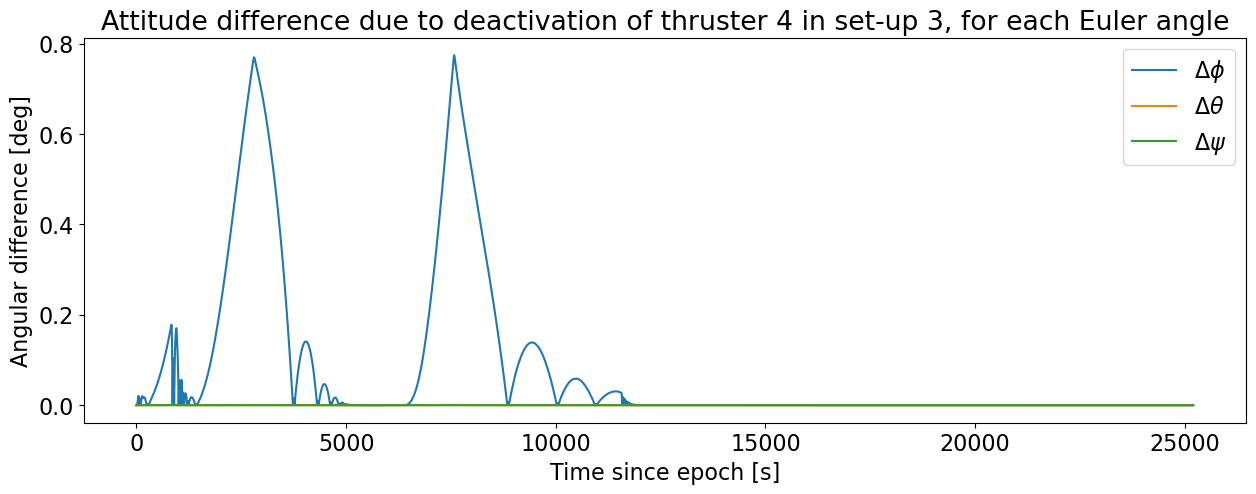

<Figure size 640x480 with 0 Axes>

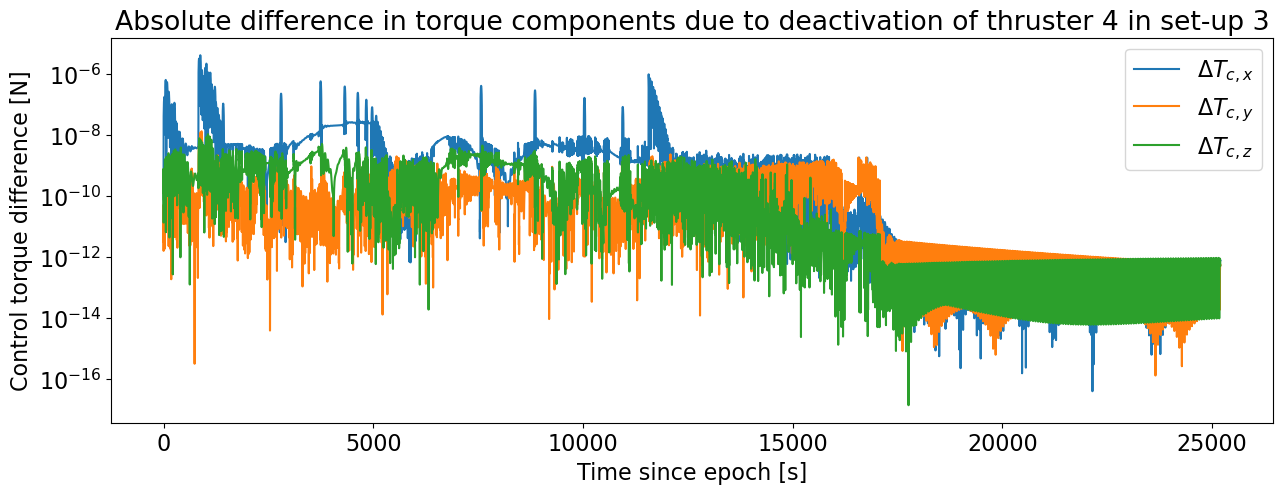

<Figure size 640x480 with 0 Axes>

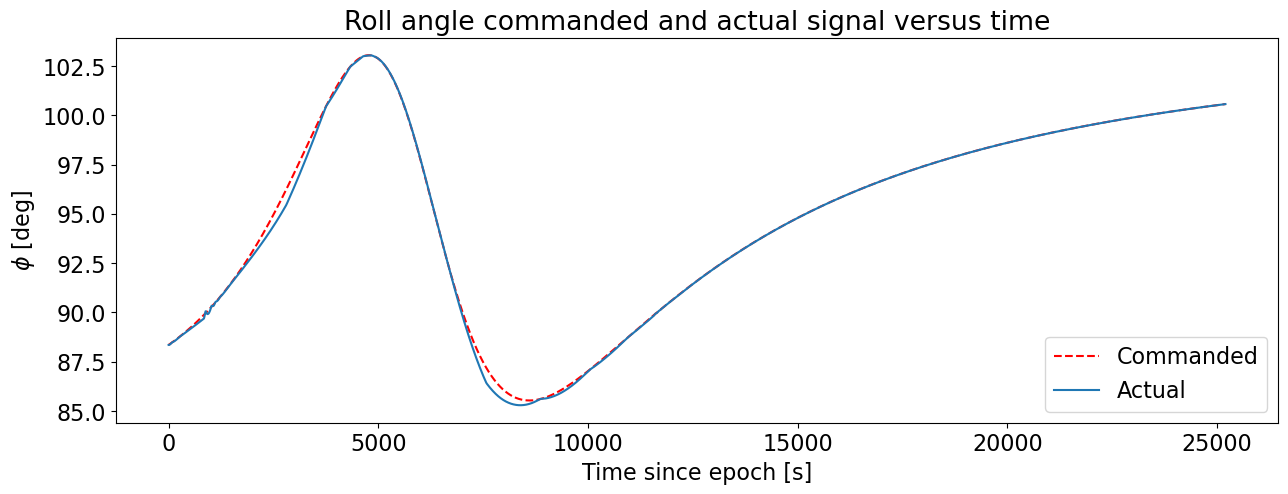

<Figure size 640x480 with 0 Axes>

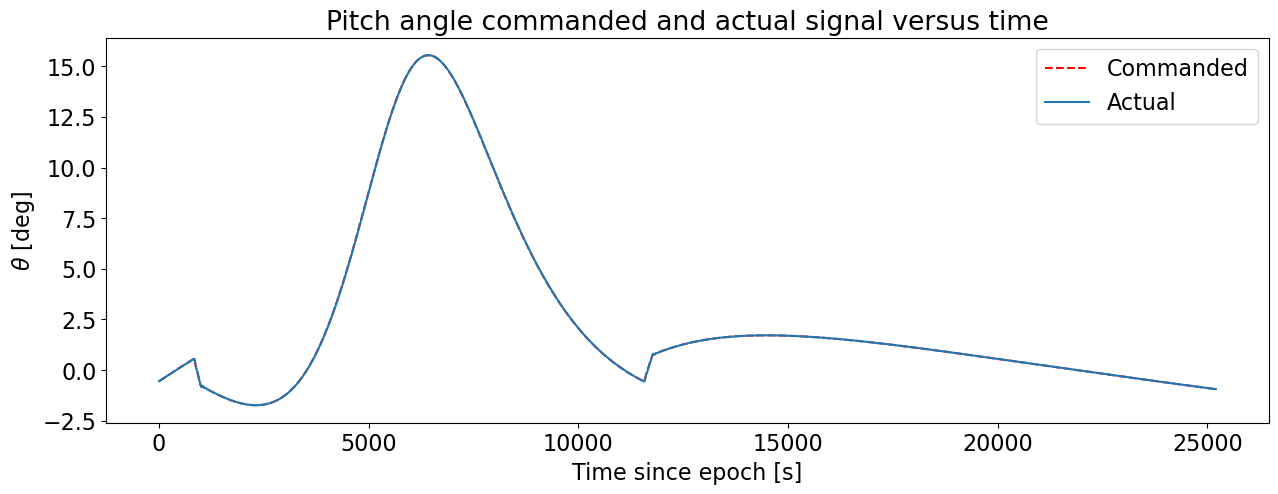

<Figure size 640x480 with 0 Axes>

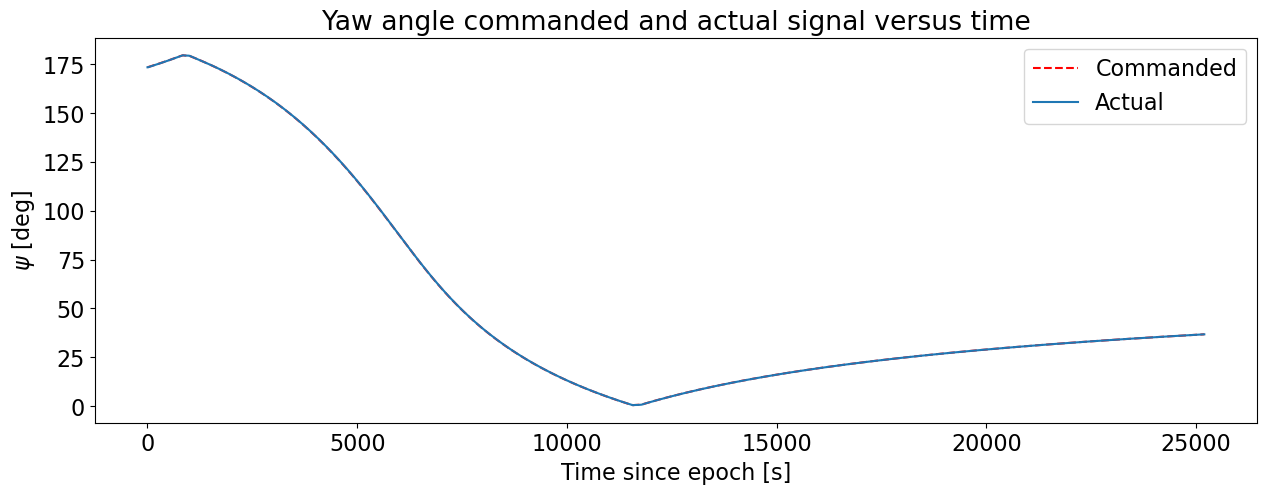

<Figure size 640x480 with 0 Axes>

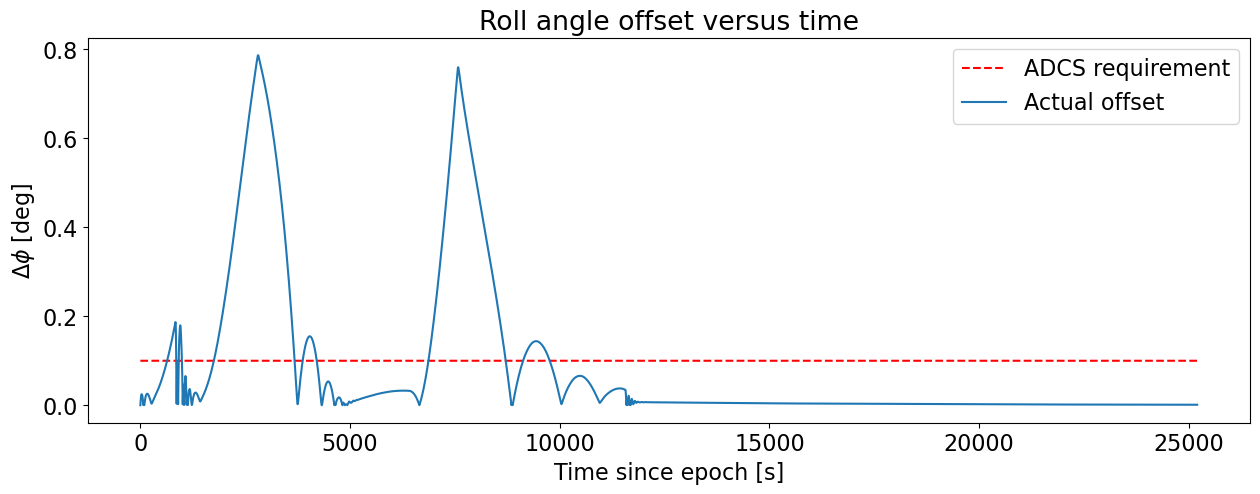

<Figure size 640x480 with 0 Axes>

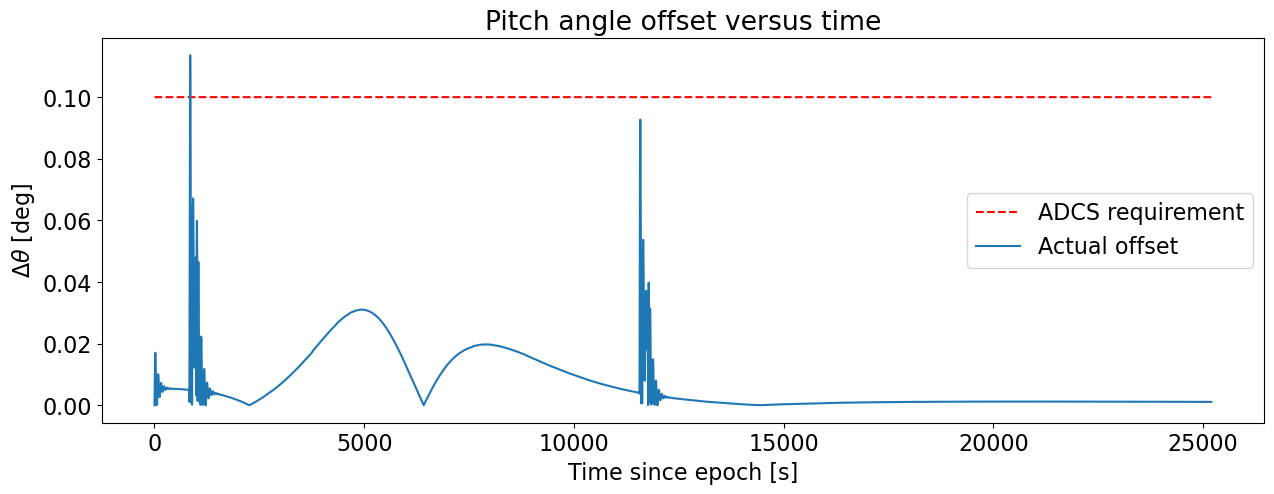

<Figure size 640x480 with 0 Axes>

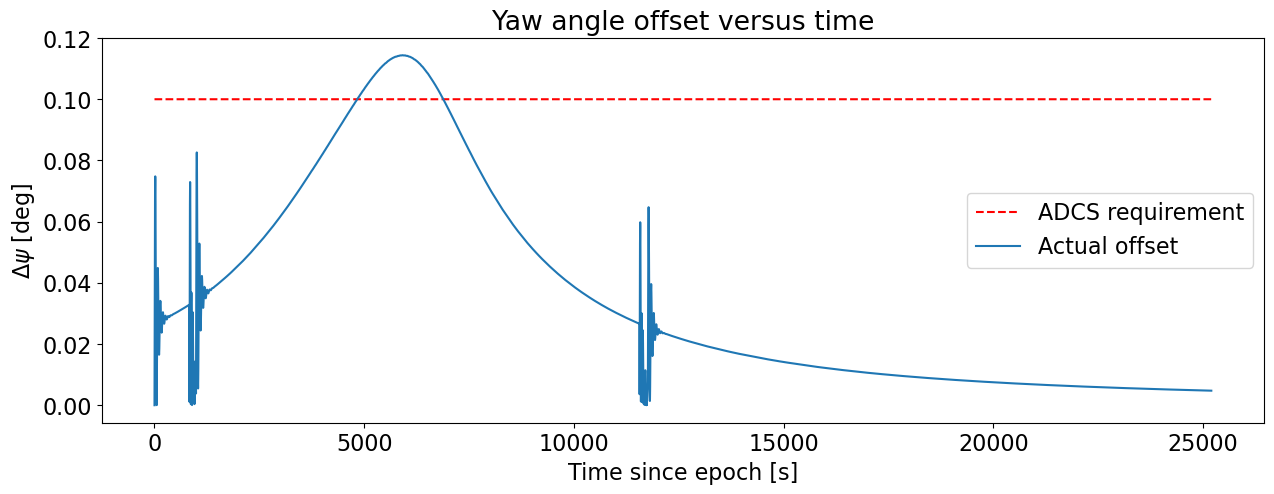

<Figure size 640x480 with 0 Axes>

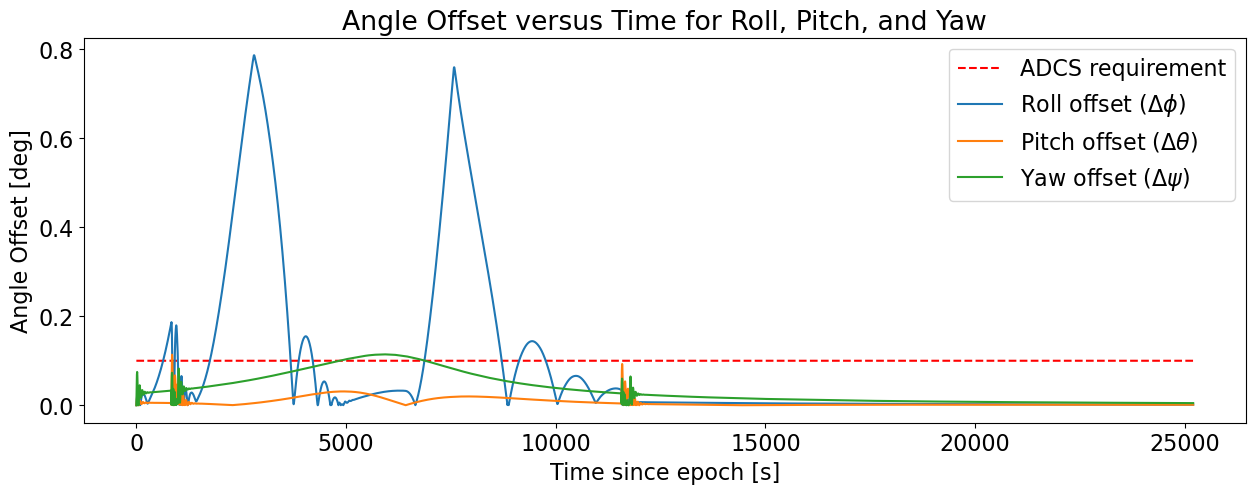

<Figure size 640x480 with 0 Axes>

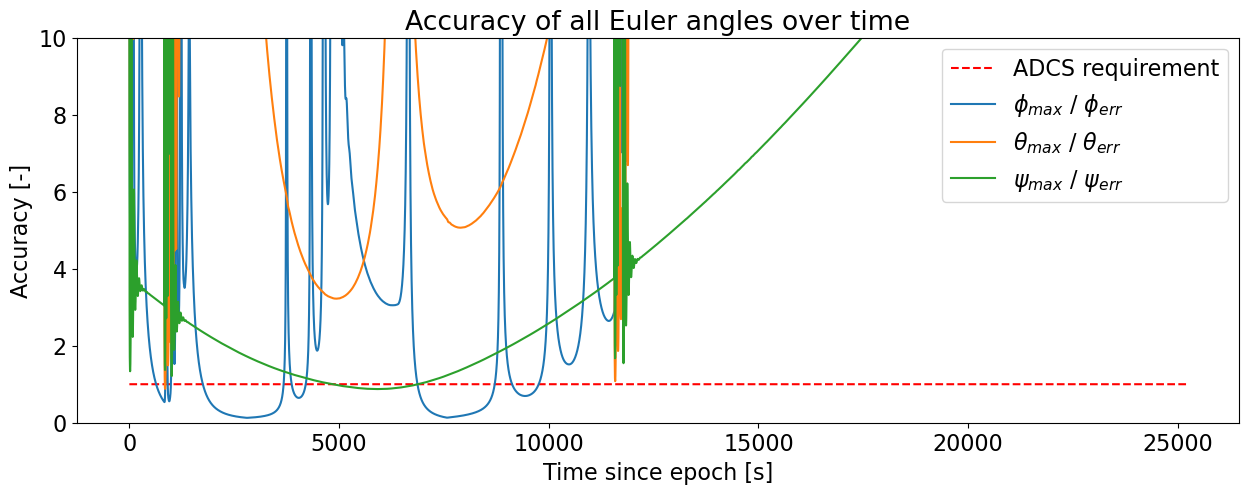

In [ ]:
vis = cl.Visualization(time_array)
rot = cl.Rotation()

euler_STF_vis = np.empty((3, len(time_array)))
euler_base_vis = np.empty((3, len(time_array)))

for index in range(len(time_array)-1):

    # Extract quaternion value for each time step
    qwr, qxr, qyr, qzr = q_STF[:, index]
    qw, qx, qy, qz = q_base[:, index]

    normr = np.sqrt(qwr**2 + qxr**2 + qyr**2 + qzr**2)
    qwr, qxr, qyr, qzr = qwr / normr, qxr / normr, qyr / normr, qzr / normr


    norm = np.sqrt(qw**2 + qx**2 + qy**2 + qz**2)
    qw, qx, qy, qz = qw / norm, qx / norm, qy / norm, qz / norm


    # Append do visualisation array
    euler_STF_vis[:, index] = np.rad2deg(rot.quaternion_to_euler(qwr, qxr, qyr, qzr))
    euler_base_vis[:, index] = np.rad2deg(rot.quaternion_to_euler(qw, qx, qy, qz))

    # print(euler_base_vis)

diff_vis = np.abs(euler_STF_vis - euler_base_vis)



plt.figure(1)
plt.figure(figsize=(15, 5))
plt.rcParams.update({"font.size": 16})
plt.plot(time_array, diff_vis[0, :], label="$\\Delta\\phi$")
plt.plot(time_array, diff_vis[1, :], label="$\\Delta\\theta$")
plt.plot(time_array, diff_vis[2, :], label="$\\Delta\\psi$")
plt.xlabel("Time since epoch [s]")
plt.ylabel("Angular difference [deg]")
plt.title("Attitude difference due to deactivation of thruster " + str(number + 1) + " in set-up 3, for each Euler angle")
plt.legend()
plt.show()

plt.figure(2)
plt.figure(figsize=(15, 5))
plt.rcParams.update({"font.size": 16})
plt.yscale('log')
plt.plot(time_array, np.abs(torque[0,:] - torque_base[0,:]), label = "$\\Delta$$T_{c,x}$")
plt.plot(time_array, np.abs(torque[1,:] - torque_base[1,:]), label = "$\\Delta$$T_{c,y}$")
plt.plot(time_array, np.abs(torque[2,:] - torque_base[2,:]), label = "$\\Delta$$T_{c,z}$")
plt.xlabel("Time since epoch [s]")
plt.ylabel("Control torque difference [N]")
plt.title("Absolute difference in control torque components due to deactivation of thruster " + str(number+1) + " in set-up 3")
plt.legend()
plt.show()

vis.euler_versus_time(q_ref, q_STF)

### Single thruster failure (STF) - Approach 3

In [ ]:
# Failure function
def simulation_STF_3(
    data_file_CAPSTONE,
    data_file_Sun,
    omega_0,
    kp,
    kd,
    ks,
    T_matrix
):
    # Load data files
    data_CAPSTONE = np.loadtxt(data_file_CAPSTONE)
    data_Sun = np.loadtxt(data_file_Sun)

    # Create time array based on the input data files and check if they cover the same epochs
    time_array = data_CAPSTONE[:, 0]
    time_array_check = data_Sun[:, 0]
    if time_array.all() != time_array_check.all():
        raise ValueError(
            "Epochs of the data files are not the same; check ephemeris retrieval."
        )

    # Obtain position data over time
    position_CAPSTONE = data_CAPSTONE[:, 1:4]
    position_Sun = data_Sun[:, 1:4]

    # Retrieve time step from data file
    dt = time_array[1] - time_array[0]

    vis = cl.Visualization(time_array)
    const = cl.Constants()
    rot = cl.Rotation()
    pd = cl.PID(const.inertia_matrix_undeployed)
    dist = cl.DisturbanceTorques(const.inertia_matrix_undeployed)

    # Initialize individual vectors for iteration
    # q = quaternion_0_vector # For custom initial condition
    q = pd.reference_quaternion_paper(position_CAPSTONE[0,:], position_Sun[0,:]) # For standard initial position
    omega = omega_0

    # Dummy values for PID
    factor_p = kp
    factor_i = 0
    factor_d = kd
    factor_s = ks

    # Create arrays
    k_p = np.array([1, 1, 1]) * factor_p
    k_i = np.array([1, 1, 1]) * factor_i
    k_d = np.array([1, 1, 1]) * factor_d
    k_s = np.array([1, 1, 1]) * factor_s


    # Initialize storage arrays for visualization
    q_ref_vis = np.empty((4, len(time_array)))
    q_vis = np.empty((4, len(time_array)))
    T_GG_vis = np.empty((3, len(time_array)))
    T_SRP_vis = np.empty((3, len(time_array)))
    T_d_vis = np.empty((3, len(time_array)))
    T_c_vis = np.empty((3, len(time_array)))
    T_RW_vis = np.empty((3, len(time_array)))
    P_RW_vis = np.empty((3, len(time_array)))
    E_RW_vis = np.empty((3, len(time_array)))
    omega_vis = np.empty((3, len(time_array)))
    h_vis = np.empty((3, len(time_array)))
    thrust_vis = np.empty((len(T_matrix[0]), len(time_array)))
    P_thrust_vis = np.empty((len(T_matrix[0]), len(time_array)))
    E_thrust_vis = np.empty((len(T_matrix[0]), len(time_array)))

    # Index count
    index = 0

    # Initiate thruster energy
    E_thrust = 0

    # Random thruster failure, select thruster
    failed_thruster = 4 # random.randint(0, len(T_matrix[0,:]) - 1)
    print(f"Thruster {failed_thruster + 1} has been disabled.")

    for t in time_array:

        # LUMIO paper-based reference quaternion update
        if index % 1 == 0:
            q_ref = pd.reference_quaternion_paper(position_CAPSTONE[index,:], position_Sun[index,:])

        # Calculate real-time disturbance torques
        T_GG = dist.GGMoon(q, position_CAPSTONE[index, :])
        T_SRP = dist.SRP(q, position_Sun[index, :], position_CAPSTONE[index, :])
        T_d = T_GG + T_SRP

        T_c = pd.control_torque(q, q_ref, omega, k_p, k_i, k_d, k_s, dt)

        ######### THRUSTER ANALYSIS #################
        # Linear Programming Solution
        thrust = cp.Variable(len(T_matrix[0]))
        constraints = [T_matrix @ thrust == T_c, thrust >= 0, thrust <= const.F_SSP_max]

        # Set the failed thruster's output to zero, approach 1
        constraints.append(thrust[failed_thruster] == 0)

        objective = cp.Minimize(cp.sum(thrust))
        problem = cp.Problem(objective, constraints)

        try:
            problem.solve(solver = cp.ECOS)

            if problem.status not in ["infeasible", "unbounded"] and thrust.value is not None:
                correct = thrust.value
                print(correct)
                
            else:
                raise cp.SolverError("Failed solution, switching to fallback.")
        except (cp.SolverError, TypeError, ValueError) as e:
            print(f"Error {e}")

            thrust = cp.Variable(len(T_matrix[0]))
            constraints = [T_matrix @ thrust == T_c, thrust >= 0, thrust <= const.F_SSP_max]

            # Set the failed thruster's output to zero, approach 1
            constraints.append(thrust[failed_thruster] == 0)

            objective = cp.Minimize(cp.sum(thrust))
            problem = cp.Problem(objective, constraints)

            try:
                problem.solve(solver = cp.ECOS)

                if problem.status not in ["infeasible", "unbounded"] and thrust.value is not None:
                    thrust_result = thrust.value
                    thrust_result[failed_thruster] = 0
                    correct = thrust_result
                else:
                    raise cp.SolverError("{problem.status}")
            except (cp.SolverError, TypeError, ValueError) as e:
                print(f"Error {e}")

        try:
            # Update the actual control torque value
            T_c = T_matrix @ correct
        except Exception as e:
            print(f"An error occurred: {e}")

        #############################################

        # Append to visualisation arrays
        q_ref_vis[:, index] = q_ref
        q_vis[:, index] = q
        T_d_vis[:, index] = T_d
        T_GG_vis[:, index] = T_GG
        T_SRP_vis[:, index] = T_SRP
        T_c_vis[:, index] = T_c
        omega_vis[:, index] = omega
        thrust_vis[:,index] = thrust.value

        # Update to t = 1
        # Integrate omega and quaternion
        omega_new = pd.rk4_integrator(pd.derivative_omega, omega, dt, T_d, T_c)
        q_new = pd.rk4_integrator(pd.derivative_quaternion, q, dt, omega)
        q = q_new / np.linalg.norm(q_new)
        omega = omega_new

        # Update index
        index += 1
    

    T_c_mag = np.sqrt(np.sum(T_c_vis**2, axis=0))
    T_d_mag = np.sqrt(np.sum(T_d_vis**2, axis=0))

    # Plot generation
    # vis.quaternion_versus_time(q_ref_vis, q_vis)
    vis.euler_versus_time(q_ref_vis, q_vis)
    # vis.control_torque_versus_time(T_c_vis)
    # vis.RW_PE_versus_time(P_RW_vis, "P")
    # vis.RW_PE_versus_time(E_RW_vis, "E")
    # vis.h_versus_time(h_vis)
    # vis.disturbance_torque_versus_time(T_d_vis)
    # vis.disturbance_torque_versus_time(T_GG_vis)
    # vis.disturbance_torque_versus_time(T_SRP_vis)
    # vis.omega_versus_time(omega_vis)
    # vis.plot_trajectories(data_file_CAPSTONE)
    # vis.thruster_PE_vs_time(P_thrust_vis, "P")
    # vis.thruster_PE_vs_time(E_thrust_vis, "E")
    # vis.combined_PE_vs_time(P_RW_vis, P_thrust_vis, "P")
    # vis.combined_PE_vs_time(E_RW_vis, E_thrust_vis, "E")
    # vis.thrust_values(thrust_vis)
    
    return "run"

Thruster 5 has been disabled.
[-1.11359311e-09 -4.71928806e-10 -1.10204980e-09 -4.84204987e-10
  3.30015562e-10 -1.14985124e-09]
[ 1.32529944e-06 -1.04655977e-09 -8.82653557e-10  5.81721767e-07
 -3.31526351e-14  8.41616560e-07]
[ 2.60676530e-06 -5.41712903e-10 -5.14992395e-10  1.14683912e-06
 -9.24318927e-14  1.65956483e-06]
[ 3.83138122e-06 -7.39722421e-10 -8.38840875e-10  1.69050615e-06
 -2.77855671e-13  2.44652458e-06]
[ 4.98938294e-06 -2.18805511e-09 -2.53336779e-09  2.20849046e-06
 -3.72310220e-14  3.19718052e-06]
[ 6.07723338e-06 -2.95011345e-11 -3.40336642e-11  2.70306148e-06
 -7.76618369e-13  3.90659895e-06]
[ 7.08164507e-06 -3.15277395e-11 -3.63057520e-11  3.16450528e-06
 -7.62008012e-13  4.57026168e-06]
[ 7.99817750e-06 -3.16400341e-11 -3.63762143e-11  3.59259999e-06
 -6.93684500e-13  5.18408569e-06]
[ 8.82117666e-06 -3.10314711e-11 -3.56002614e-11  3.98492490e-06
 -6.21627373e-13  5.74444800e-06]
[ 9.54596344e-06 -3.01993511e-11 -3.45554783e-11  4.33937741e-06
 -5.58696882e-

<Figure size 640x480 with 0 Axes>

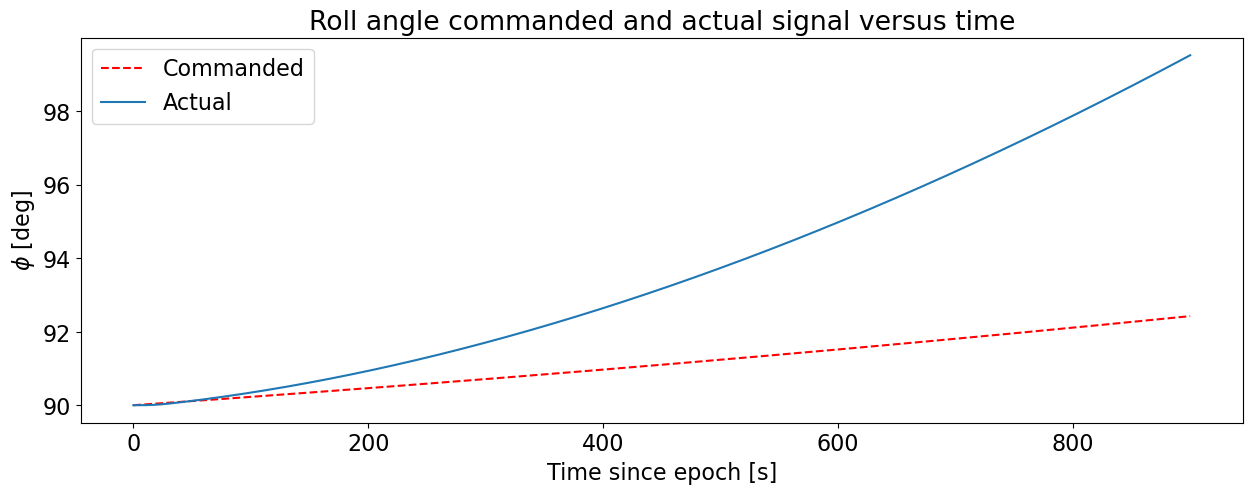

<Figure size 640x480 with 0 Axes>

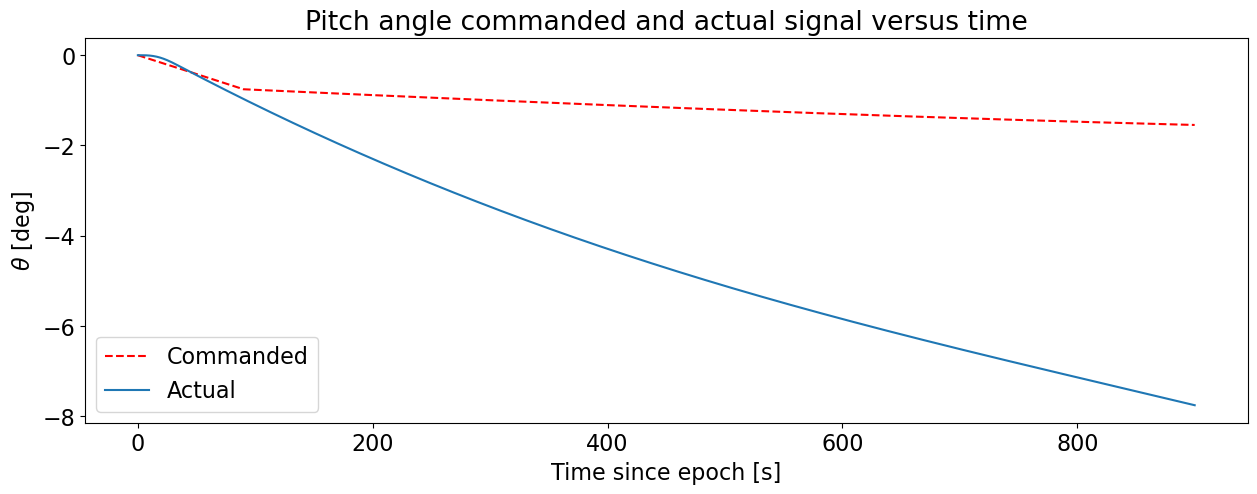

<Figure size 640x480 with 0 Axes>

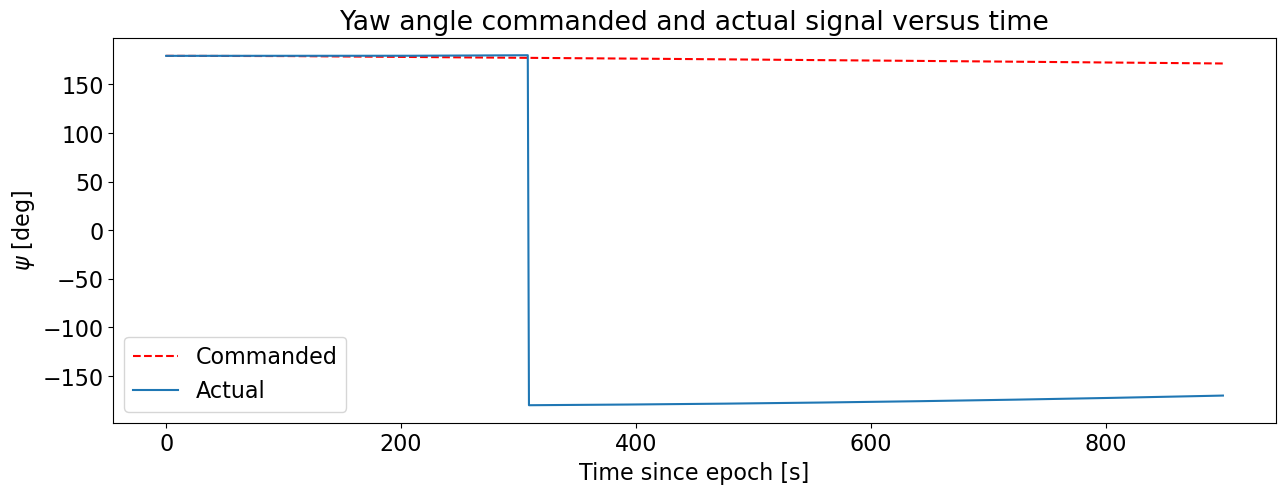

<Figure size 640x480 with 0 Axes>

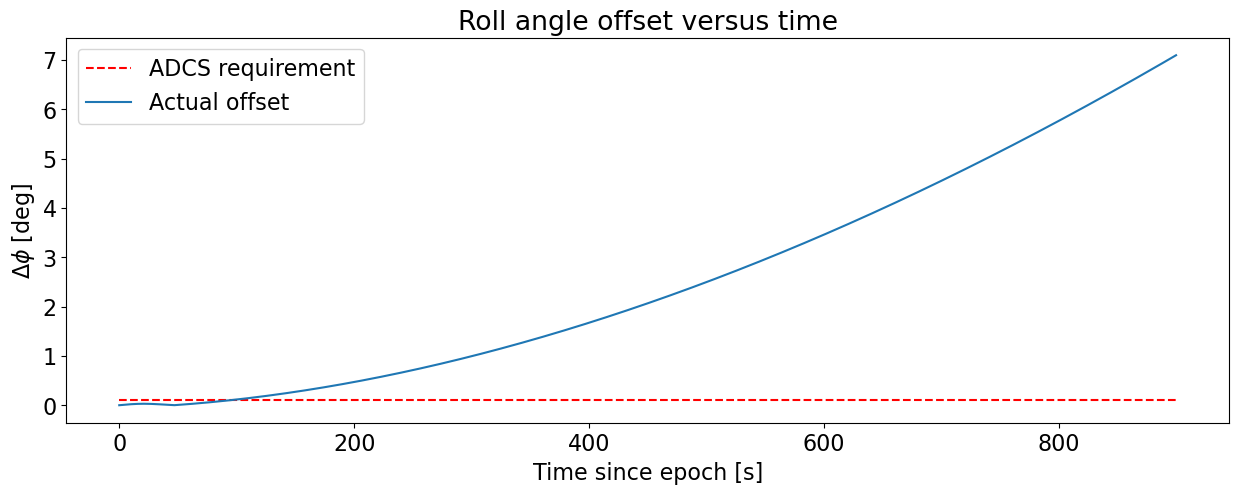

<Figure size 640x480 with 0 Axes>

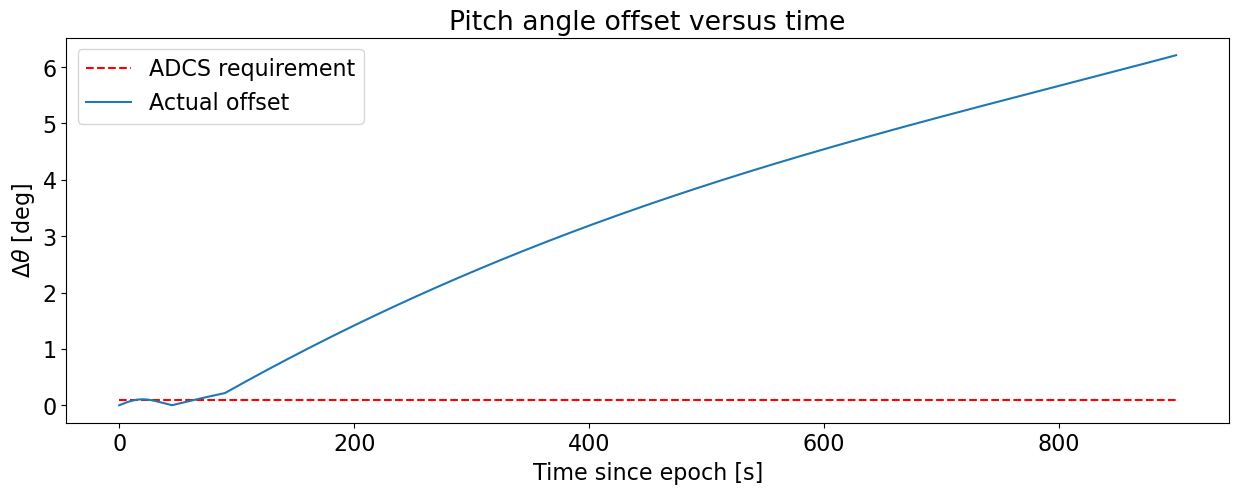

<Figure size 640x480 with 0 Axes>

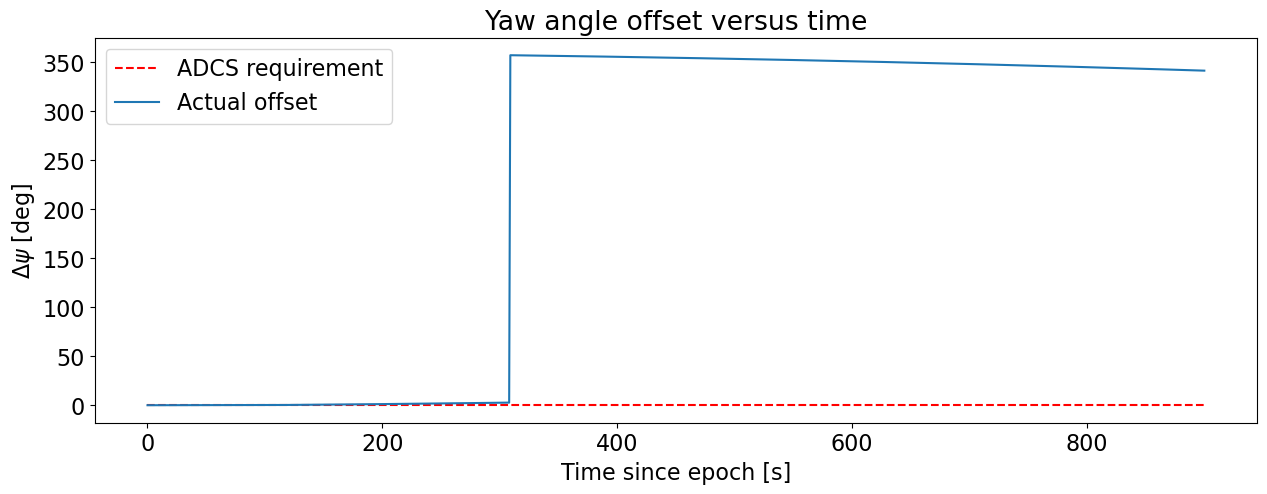

<Figure size 640x480 with 0 Axes>

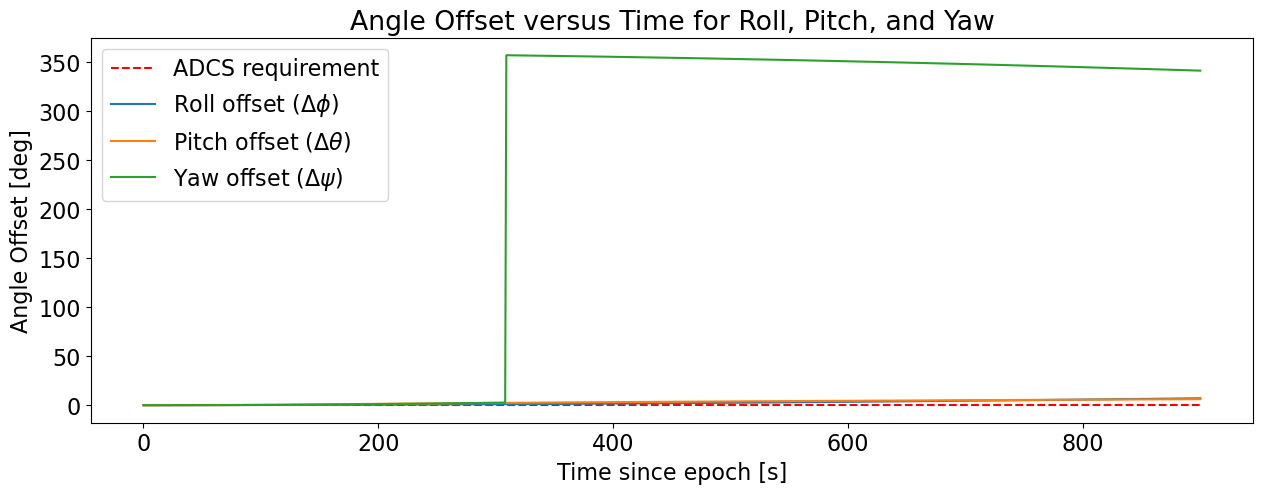

/Users/pieter/Library/Mobile Documents/com~apple~CloudDocs/Thesis/Research Phase/lunar_CubeSat/classes.py:1070: RuntimeWarning: divide by zero encountered in divide
  plt.plot(self.t, acc_req / euler_offset_vis[0, :], label="$\phi_{max}$ / $\phi_{err}$")
/Users/pieter/Library/Mobile Documents/com~apple~CloudDocs/Thesis/Research Phase/lunar_CubeSat/classes.py:1071: RuntimeWarning: divide by zero encountered in divide
  plt.plot(self.t, acc_req / euler_offset_vis[1, :], label="$\\theta_{max}$ / $\\theta_{err}$")
/Users/pieter/Library/Mobile Documents/com~apple~CloudDocs/Thesis/Research Phase/lunar_CubeSat/classes.py:1072: RuntimeWarning: divide by zero encountered in divide
  plt.plot(self.t, acc_req / euler_offset_vis[2, :], label="$\psi_{max}$ / $\psi_{err}$")


<Figure size 640x480 with 0 Axes>

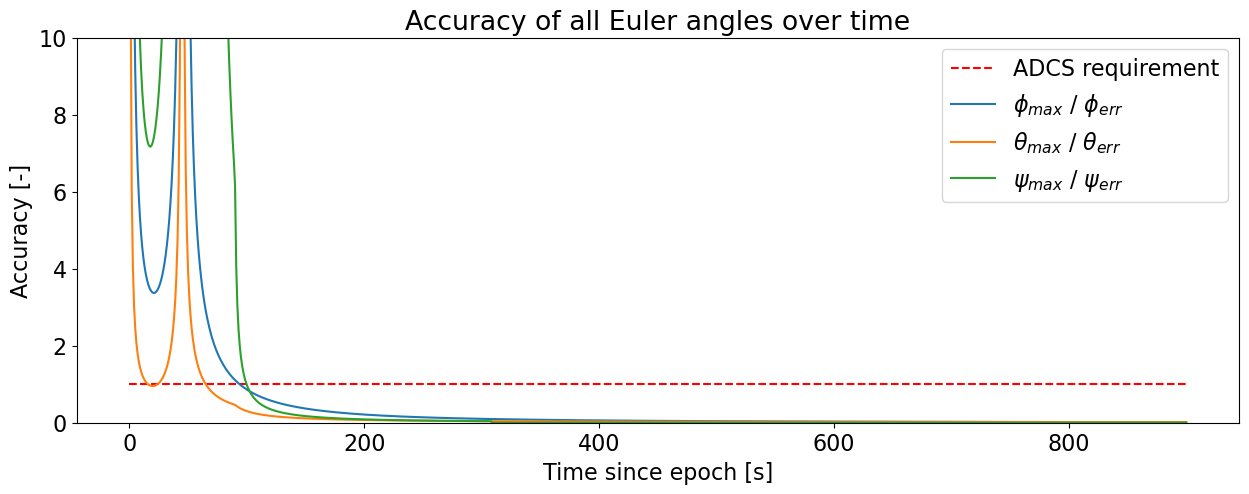

'run'

In [ ]:
# Initiation
omega_0 = np.array([-1.46736360e-08 , 9.64721725e-09 , 4.04781774e-08])

# Including the reference omega, not working
kp = 5e-4
kd = 1e-3
ks = 9

simulation_STF_3(
"converted_ephemeris_data/converted_1s_cartesian_coordinates_CAPSTONE_Moon-centered_2023-01-05 08:15_to_2023-01-05 08:30_1m.dat",
"converted_ephemeris_data/converted_1s_cartesian_coordinates_Sun_Moon-centered_2023-01-05 08:15_to_2023-01-05 08:30_1m.dat",
omega_0,
kp,
kd,
ks,
T_matrix_2)